### Aource: https://towardsdatascience.com/python-hamiltonian-monte-carlo-from-scratch-955dba96a42d
# Introduction

Hello and thank you taking time to review this notebook! 

The below are Markov Chain Monte Carlo algorithms implemented by myself, Jacob Moore, for IDS 576: Advanced Predictive Models, a course in the Information and Decision Sciences (IDS) department at the University of Illinois at Chicago.

This notebook is a resource for current/former IDS 576 students, studying Bayesian Inference (or anyone else interested) 

If you have any questions/concerns about the contents, feel free to contact me:

jacob.d.moore1@gmail.com

Cheers!

# Metropolis Algorithm

This algorithm is the prototypical MCMC method (Markov Chain Monte Carlo.) It simply starts with a randomly generated value as "current" then iteratively proposes a pertrubation and adjusts current by this value, which is referenced as "movement."

The real trick is quantifying how *appealing* the proposed movement is. Using the target distribution's probability density function, PDF, the likelihoods of both "current" and "movement" can be evaluated. This likelihood ratio represents how attractive/appealing the proposed movement is to the algorithm. When the current location has a high likelihood and the proposed location has a low likelihood, the ratio approaches 0. Conversely, when the current likelihood is very small and the proposed likelihood is very large, the ratio can approach (or even exceed!) 1.

To make use of this ratio, a random event is observed (namely, a random number in the range [0,1]). If the random number is less than or equal to the ratio, move. Otherwise, stay.

That's basically it! But...Why does it work? 

Consider Markov Chains (MC) (ie a "memoryless" system, where the future is only dependent on the present and the past can be discarded.) Several systems can be represented as an MC, perhaps the most famous is Google's PageRank. The internet is essentially a network/graph of pages are linked together. The algorithm starts with a naive guess that each page is equally ranked (for 4 pages, the vector [0.25, 0.25, 0.25, 0.25] represents this "prior" belief.)  How do we evaluate what page should be ranked the highest? And what does this represent?  

To answer this question, we look at the transition matrix (a matrix of inbound/outbound links between each page; the less pages a given page links to, the more important that link is. The more pages that a given page links to, the less important that link is.) 

One strategy available is a random walk. A "bot" can be sent to explore this graph for a set number of iterations. At each iteration, the bot moves to another page according to the Probability Mass Function, PMF, available. After hundres (or thousands) of iterations, some web pages will be visited more often than others and necessarily, their ranks should be higher than the pages less frequently visited. In fact, the relative proportion of each page in this PMF is called the "stationary distribution" - it's the long run behavior of the graph. Or more simplsistically, if we abruptly stopped our bot on any given iteration, *what's the probability that it was visiting a given page at the time of the interruption?*   

The stationary distribution answers precisely this question! (Note: the stationary distribution of a markov chain's PMF is the eigenvector of the transition matrix and can be found much more quickly than by thousands of random walks. Nonetheless, keep random walks "in mind.")

So what does this have to do with MCMC methods? First, MCMC techniques often sample continuous distributions. The biggest insight is that - *there is no transition matrix!* Instead, we use a transition kernel. This kernel depicts the relative likelihood of a movement from one continuous state to another. In fact, this is why we use the likelihood ratio!

So after sampling the target distribution for a given number of iterations, we arrive at the stationary distribution for the continuous equivalent of the PMF markoc chain discussed above.

Note: This algorithm only works when the proposal distribution is symmetric (more on this later,)

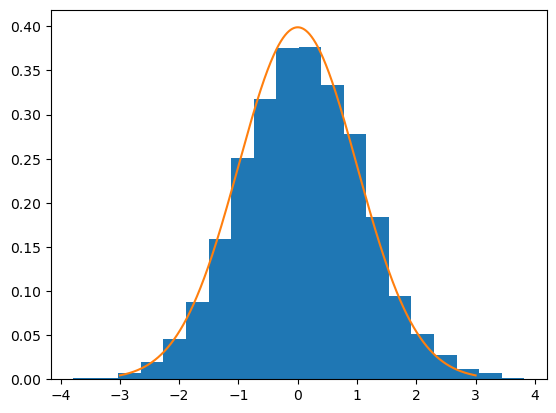

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

def normal(x,mu,sigma):
    numerator = np.exp((-(x-mu)**2)/(2*sigma**2))
    denominator = sigma * np.sqrt(2*np.pi) #Note that sigma, a parameter, is in the denominator
    return numerator/denominator  #so the denominator cannot cannot be ommitted
    
def gaussian_mcmc(hops,mu,sigma):
    states = []
    burn_in = int(hops*0.2)
    current = random.uniform(-1*sigma+mu,1*sigma+mu)
    for i in range(hops):
        states.append(current)
        movement = current + random.uniform(-0.25,0.25)
        
        curr_prob = normal(x=current,mu=mu,sigma=sigma)
        move_prob = normal(x=movement,mu=mu,sigma=sigma)
        
        acceptance = move_prob/curr_prob
        event = random.uniform(0,1)
        if acceptance > event:
            current = movement
            
    return states[burn_in:]


mu, sigma = 0,1
dist = gaussian_mcmc(100_000,mu=mu,sigma=sigma)
lines = np.linspace(-3,3,10_000)
normal_curve = [normal(x=l,mu=mu,sigma=sigma) for l in lines]

plt.hist(dist,bins=20,density=True) 
plt.plot(lines,normal_curve)

## Metropolis Algorithm for Bayesian Inference

In the above example, we used the gaussian PDF in Metropolis algorithm to sample from the distribution. But the whole purpose of the PDF is to inform us how likely a current position is (under that PDF) compared to a proposed position (under the same PDF.) Implicitly, we only need a function that proportional to the target distribution; it's summation/integral need not sum to 1. 

Because of this, application to Bayesian Inference is readily available. Consider that we are comparing two marketing campaigns in terms of purchases or failures to purchase. (Or heads to tails in coin tosses.) Say we'd like to model our prior belief and posterior belief with the Beta distribution. One way to accomplish this is via the conjugate prior pair, Beta (prior) and  Binomial  (likelihood).

The idea is that we have a prior belief about successes to failures, captured by parameters (theta, a, and b) in the Beta distribution. Then we conduct a small experiment where k successes are observed in n trials, and we model these results in the Binomial distribution via parameters (theta, n, and k). We find that when we multiply the the prior by the likelihood, we get the right shape but the function doesn't integrate to 1 (meaning it's not a valid probability distribution.) 

We need to scale this distribution by some constant, ensuring that it integrates to 1. In Bayesian terms, we need the "evidence" which is the probability of observing this data (from our experiment) under all possible values which theta can take on. 

We've seen that the prior * likelihood is a function, defined by the variable theta and constants, (a,b,n,k). If theta were a single constant, the prior * likelihood would not be a function, it would be a simple constant. If we integrate prior*likelihood with respect to every possible theta value, the result is a constant. It's a scaling value that ensures our prior * likelihood integrates to 1. 

Unfortunately, it's extremely tedious evaluating this integral. As such, there are two solutions, which sidestep the integral calculation entirely: (A) use conjuagte priors, which are only possible solutions in specific, simple porblems - including this one. And (B) Use MCMC methods to simulate samples from the distribution. 

In our case, we will be using the Metropolis algorithm to sample from the posterior. Below, you'll see three variations which all achieve the same effect, progressively, they eliminate terms and improve performance. Let's see why!

First, in numerator1, we can exclude the denominator (ie the constant derived by the intrgal.) As discussed previously, Metropolis starts at an arbitrary point. The proposal distribution, simply proposes successive movements from this arbitrary location and they are accepted or rejected based on the ratio of their likeliness. To determine likeliness, we don't need the full PDF (to include the denominator), we simply need something proportional to PDF. 

You'll see that we're using Beta and Binom functions from scipy.stats. The Beta PDF includes Euler's Beta function in the dnominator, which is quite expensive to evaluate, however, it is unchanging given a fixed values for a and b, which we can assume.

In numerator2, we only supply the non-constant (scaling) terms for the Beta function and define our own binomial function in the term t2. However, the binomial function is also expensive to evaluate because of the combinations term. Factorials are generally expensive to compute and if this step is executed for every current and proposed position, we're incurring quite a bit of expensive computations.

In numerator3, we build upon the previous function by removing the combinations term, eliminating the expensive computational requirement. This is possible because combinations(n,k) will always evaluate to the same constant, given fixed values for n and k. Just like the Euler Beta function, which we removed, theta is the only variable. As such, we can remove all terms that do not explicitly involve theta. 

The key idea here is that when doing Bayesian inference, you need only the prior and likelihood to sample from the posterior; you can omit the computationally expensive integral altogether. And because we've established that scaling constants don't affect the likelihood ratio, we can remove them from the functions used to evaluate the likeliness ratio when comparing current and proposed positions!

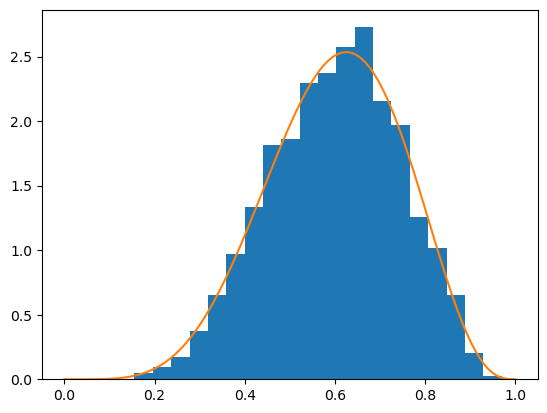

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import beta

def numerator1(theta,a,b,n,k):
    ## Much slower because beta.pdf computes Euler's beta function - computation heavy!
    t1 = beta.pdf(x=theta,a=a,b=b)
    t2 = binom.pmf(k=k,n=n,p=theta)
    return t1*t2

def combinations(n,k):
    ## Not needed in MCMC because it also cancels out!
    return np.math.factorial(n)/(np.math.factorial(k)*np.math.factorial(n-k))

def numerator2(theta,a,b,n,k):
    ## Much faster because Euler's beta function in beta.pdf does not need to be evaluated
    ## because it cancels out!
    t1 = theta**(a-1)*(1-theta)**(b-1) # proportional to prior
    t2 = combinations(n,k)*theta**(k)*(1-theta)**(n-k) # But is this necessary? It cancels out! 
    return t1*t2

def numerator3(theta,a,b,n,k):
    ## Much faster because Euler's beta function in beta.pdf does not need to be evaluated
    ## because it cancels out!
    t1 = theta**(a-1)*(1-theta)**(b-1) # proportional to prior
    t2 = theta**(k)*(1-theta)**(n-k) # proportional to likelihood
    return t1*t2    

def beta_binom_mcmc(hops,a,b,n,k):
    states = []
    burn_in = int(hops*0.2)
    current = 0.5
    for i in range(hops):
        states.append(current)
        movement = current + random.uniform(-0.2,0.2)
        
        curr_prob = numerator3(theta=current,a=a,b=b,n=n,k=k)
        move_prob = numerator3(theta=movement,a=a,b=b,n=n,k=k)
        
        acceptance = move_prob/curr_prob
        event = random.uniform(0,1)
        if acceptance > event:
            current = movement
            
    return states[burn_in:]

bb_samples = beta_binom_mcmc(hops=10_000,a=3,b=2,n=5,k=3)
plt.hist(bb_samples,density=True,bins=20)
post_samples = [beta.pdf(a=6,b=4,x=p) for p in np.linspace(0,1,100)]
plt.plot(np.linspace(0,1,100),post_samples)    

# Metropolois-Hastings (MH) algorithm

In the above code, the proposal distribution is uniform. In other words, when introduce preturbations, there is no bias towards either tail (or the peak) of the gaussian. However, if we were to propose movements in such a way that positive numbers were far more likely than negative numbers, we would over-explore the right side of the distribution, but fail to adequately explore the left side.

The Metropolis-Hastings algorithm updates the Metropolis algorithm by comparing the likelihood ratio of the preturbations drawn from the proposal distribution. This corrects for the effects of an asymmetric proposal distribution. 

The below is a "toy example" sampling from an exponential distribution. A beta distribution with parameters (a=3,b=2) is used. The Beta PDF is defined for x in range [0,1]. With the parameters listed, the Beta distribution will propose movements biased above 0.5 and will propose movements below 0.5 less frequently. Note: Because the proposal distribution is defined [0,1] is never samples negative movements and will continuously increase or reject an increase - but the proposed value will never be lower than the current value.

To combat this, the proposal distribution has been defined as `Beta(a=3,b=2) - 0.5`. This distribution will more often sample proposed increases, but will on occasion sample proposed decreases.

As you'll see, we will define a `correct` function, which receives the current value and the proposed value, finds the differences between the 2 and adds 0.5 to acount for the -0.5 bias mentioned previously. Then these differences will be delivered to the Beta PDF so that their likelihoods can be evaluated. Lastly, the ratio of these likelihoods will be stored in a temporary variable, "correction". This only difference between M and MH is that the correction is multiplied against the acceptance variable in order to correct for asymmetry and ensure that the MCMC method does arrive at the MC's stationary distribution (ie actually sample from the distribution.)

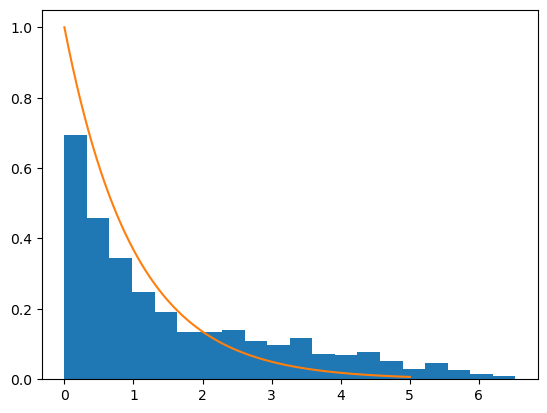

In [3]:
from scipy.stats import beta

def target(x,lam):
    return int(x>0) * lam * np.exp(-x * lam)

def correct(prop,curr,a=3,b=2):
    x0 = curr - prop + 0.5
    x1 = prop - curr + 0.5
    b0 = beta.pdf(x=x0, a=a, b=b)
    b1 = beta.pdf(x=x1, a=a, b=b)
    return b0/b1 

def exponential_MH(hops,lam=3):
    states = []
    burn_in = int(hops*0.2)
    current = 1
    
    for i in range(hops):
        states.append(current)
        movement = current + np.random.beta(a=3,b=2)-0.5 # requires assymetric correction        
        correction = correct(curr=current,prop=movement)
        acceptance = target(x=movement,lam=lam)/target(x=current,lam=lam)*correction
        event = random.uniform(0,1)
        if acceptance > event:
            current = movement
            
    return states[burn_in:]        
        
lam = 1
exp_samples = exponential_MH(hops=10_000,lam=lam)
lines = np.linspace(0,5,10_000)
exp_curve = [lam*np.exp(-l*lam) for l in lines]

plt.hist(exp_samples,density=True,bins=20) 
plt.plot(lines,exp_curve)        

# Bayesian Linear Regression

In the Bayesian approach to linear regression, rather than solving for point estimates for slope, b, y-intercept, a, and error, s, simulations are drawn of various values that these variables could take on. The biggest change (from previous sections in this notebook) is that we don't simply have one likelihood, we have several: One for each observed (x,y) pair. The overall likelihood is simply the product (or sum of logs) of each individual likelihood. 

To evaluate a likelihood, simply evaluate the PDF, with mean `y(i)` at `b*x(i) + a`. Likewise, the Bayesian approach allows for prior beliefs on each parameter to be incorporated into the model (which frequentist statistics does not allow for.) Below, b and a receive gaussian priors, whereas sigma receives an inverse gamma prior.

The design will iteratively propose movements to one variable at a time, if the sum of log-likelihoods and log priors is sufficiently higher than that of the previous iteration, a movement will be observed, otherwise, the sampler will stay in its current position.  


**Data generation**

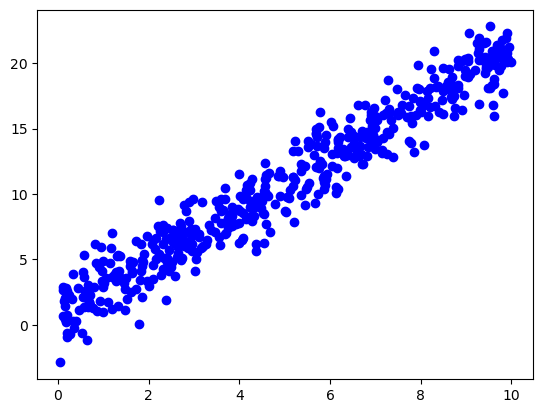

In [4]:
import numpy as np
import matplotlib.pyplot as plt

sample_size = 500
sigma_e = 1.5             # true value of parameter error sigma
random_num_generator = np.random.RandomState(0)
x = 10.0 * random_num_generator.rand(sample_size)
e = random_num_generator.normal(0, sigma_e, sample_size)
y = 1.0 + 2.0 * x +  e          # a = 1.0; b = 2.0; y = a + b*x
plt.scatter(x, y, color='blue')

**Prior beliefs on distribnution of b0 and b1**

/tmp/ipykernel_4632/3034044163.py:59: RuntimeWarning: overflow encountered in exp
  ratio = np.exp(movement_numerator - current_numerator)
/tmp/ipykernel_4632/3034044163.py:70: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(x=[test[i][0] for i in range(len(test))], y=[test[i][1] for i in range(len(test))], cmap="inferno",shade=True)


[(1.9, 2.07), (0.5, 1.2)]

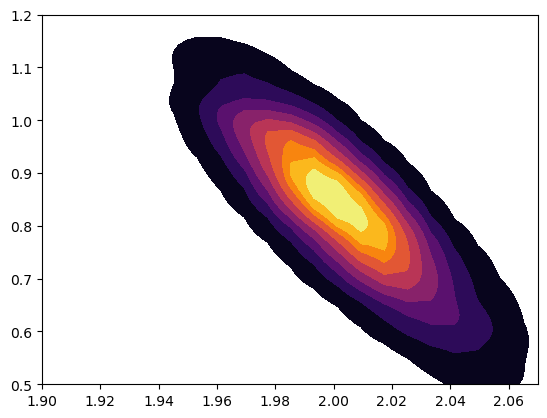

In [9]:
import numpy as np
import random
import seaborn as sns

def normalPDF(x,mu,sigma):
  num = np.exp(-1/2*((x-mu)/sigma)**2)
  den = np.sqrt(2*np.pi)*sigma
  return num/den

def invGamma(x,a,b):
  non_zero = int(x>=0)
  func = x**(a-1)*np.exp(-x/b)
  return non_zero*func

def lr_mcmc(X,Y,hops=10_000):
  samples = []
  curr_a = random.gauss(1,1)
  curr_b = random.gauss(2,1)
  curr_s = random.uniform(3,1)

  prior_a_curr = normalPDF(x=curr_a,mu=1,sigma=1)
  prior_b_curr = normalPDF(x=curr_b,mu=2,sigma=1)
  prior_s_curr = invGamma(x=curr_s,a=3,b=1)
  
  log_lik_curr = sum([np.log(normalPDF(x=curr_b*x + curr_a,mu=y,sigma=curr_s)) for x,y in zip(X,Y)])
  current_numerator =  log_lik_curr + np.log(prior_a_curr) + np.log(prior_b_curr) + np.log(prior_s_curr)

  count = 0
  for i in range(hops):
    samples.append((curr_b,curr_a,curr_s))    

    if count == 0: #propose movement to b
      mov_a = curr_a
      mov_b = curr_b + random.uniform(-0.25,0.25) 
      mov_s = curr_s
      count += 1

    elif count == 1: #propose movement to a
      mov_a = curr_a + random.uniform(-0.25,0.25)
      mov_b = curr_b
      mov_s = curr_s
      count += 1

    else: #propose movement to s
      mov_a = curr_a
      mov_b = curr_b
      mov_s = curr_s + random.uniform(-0.25,0.25)
      count = 0

    prior_b_mov = normalPDF(x=mov_b,mu=2,sigma=1)
    prior_a_mov = normalPDF(x=mov_a,mu=1,sigma=1)
    prior_s_mov = invGamma(x=mov_s,a=3,b=1)
    if prior_s_mov <=0: 
      continue #automatically reject because variance cannot equal 0.
    
    log_lik_mov = sum([np.log(normalPDF(x=mov_b*x + mov_a,mu=y,sigma=mov_s)) for x,y in zip(X,Y)])
    movement_numerator = log_lik_mov + np.log(prior_a_mov) + np.log(prior_b_mov) + np.log(prior_s_mov)
  
    ratio = np.exp(movement_numerator - current_numerator)
    event = random.uniform(0,1)
    if event <= ratio:
      curr_b = mov_b
      curr_a = mov_a
      curr_s = mov_s
      current_numerator = movement_numerator
      
  return samples

test = lr_mcmc(Y=y,X=x,hops=25_000)
g = sns.kdeplot(x=[test[i][0] for i in range(len(test))], y=[test[i][1] for i in range(len(test))], cmap="inferno",shade=True)
g.set(xlim=(1.9,2.07),ylim=(0.5,1.2))

Above, the distribution shows that the highest explored region is near the point (2.01, 0.84) corresponding to the slope and y-intercept respectively. The actual synthetic data had a slope of 2.0 and a y-intercept of 1.0. Not bad! Note the diagonal pattern, where an increase in slope necesitates a reduction in y-intercept and vice versa. Departures from this pattern result in rapid reductions in likelihood. 

Likewise, the error has been estimated, with a peak around 1.45, where the actual variance of the synethetic data is 1.5.

(array([8.89150614e-02, 6.75754466e-01, 2.45405569e+00, 5.24154287e+00,
        7.69115281e+00, 8.40247330e+00, 6.28333100e+00, 3.71664956e+00,
        1.57379659e+00, 5.73502146e-01, 1.64492864e-01, 3.11202715e-02,
        4.44575307e-03, 0.00000000e+00, 8.89150614e-03, 4.44575307e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.11202715e-02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.11202715e-02, 4.44575307e-03,
        4.44575307e-03, 0.00000000e+00, 1.33372592e-02, 0.00000000e+00,
        8.89150614e-03, 1.77830123e-02, 0.00000000e+00, 8.89150614e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.44575307e-03,
        4.44575307e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 4.44575307e-03]),
 array([1.3394647 , 1.36645675, 1.39344881, 1.42044086, 1.44743291,
        1.47442496, 1.5014

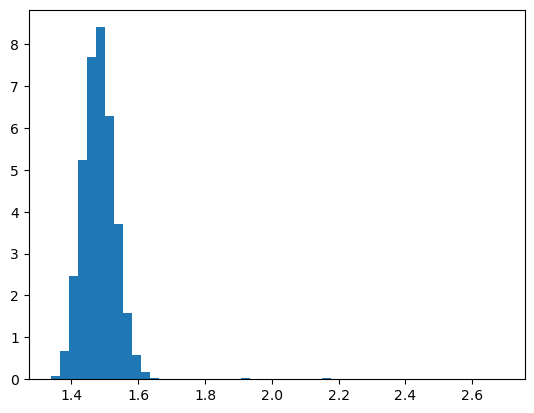

In [6]:
plt.hist([test[i][2] for i in range(len(test))],bins=50,density=True,)

# Bayesian Logistic Regression

Our approach to Bayesian logistic regression is very similar to the above approach to linear regression. This time we'll supply two independent variables, x1 and x2, and predict a binary dependent variable, y1. After this we must transform the real number line `(-inf, inf)` to a `(0,1)` scale. The sigmoid function accomplished this very effect! We'll call this transformed paramter, P. 

Lastly, we need a likelihood function that returns the probability of belonging to the correct class. P is the estimated probability that the given observation belongs to class 1. 1-P is the probability that the observation belongs to the other binary class, 0. So, we essentially need the Bernoulli function which returns P or 1-P depending on if the true class is 1 or 0. We will use the loss function `P**y*(1-P)**(1-y)`. To verify this effect, consider what we be returned when y equals 0 versus when y equals 1.

In [10]:
from scipy.stats import binom #A single binomial trial IS a Bernoulli trial
binom.pmf(n=1,k=1,p=0.6) #n trials, k successes, with p probability of success

0.6

In [11]:
binom.pmf(n=1,k=0,p=0.6)

0.4

**Data generation**

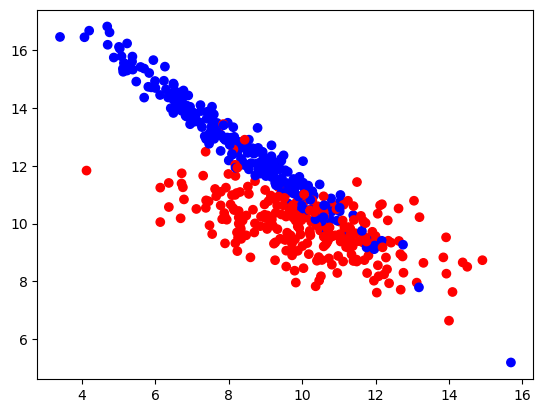

In [12]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
import matplotlib
import matplotlib.pyplot as plt

X,Y = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, 
                          n_classes=2, n_clusters_per_class=1, weights=None, flip_y=0, class_sep=30.0,
                          hypercube=False,shift=5.0, scale=2.0, shuffle=True,random_state=1)

colors=['red','blue']
plt.scatter(x=X[:,0],y=X[:,1],c=Y,cmap=matplotlib.colors.ListedColormap(colors))

**Defining the model**

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import random
def sigmoid(z):
  return 1/(1+np.exp(-z))

def normalPDF(x,mu,sigma):
  num = np.exp(-1/2*((x-mu)/sigma)**2)
  den = np.sqrt(2*np.pi)*sigma
  return num/den

def bernoulli(p,y):
  return (p)**y * (1-p)**(1-y)  

def logreg_mcmc(X,Y,hops=10_000):  
  samples = []
  curr_b0 = 0
  curr_b1 = 0
  curr_b2 = 0

  prior_curr_b0 = normalPDF(x=curr_b0,mu=1,sigma=1)
  prior_curr_b1 = normalPDF(x=curr_b1,mu=1,sigma=1)
  prior_curr_b2 = normalPDF(x=curr_b2,mu=1,sigma=1)

  P = [sigmoid(z= curr_b1 * x1 + + curr_b2 * x2 + curr_b0) for x1,x2, in X]
  curr_log_lik = sum([np.log(bernoulli(p=pi,y=yi)) for pi,yi in zip(P,Y)])
  current = curr_log_lik + np.log(prior_curr_b0) + np.log(prior_curr_b1) + np.log(prior_curr_b2) 

  count = 0
  for i in range(hops):
    samples.append((curr_b0,curr_b1,curr_b2))
    
    if count == 0:
      mov_b0 = curr_b0 + random.uniform(-0.25,0.25)
      mov_b1 = curr_b1
      mov_b2 = curr_b2
      count +=1

    elif count == 1:
      mov_b0 = curr_b0 
      mov_b1 = curr_b1 + random.uniform(-0.25,0.25)     
      mov_b2 = curr_b2
      count += 1 

    else:
      mov_b0 = curr_b0 
      mov_b1 = curr_b1 
      mov_b2 = curr_b2 + random.uniform(-0.25,0.25)
      count = 0          

        
    prior_mov_b0 = normalPDF(x=mov_b0,mu=1,sigma=1)
    prior_mov_b1 = normalPDF(x=mov_b1,mu=1,sigma=1)
    prior_mov_b2 = normalPDF(x=mov_b2,mu=1,sigma=1)

    P = [sigmoid(z= mov_b1 * x1 + + mov_b2 * x2 + mov_b0) for x1,x2, in X]
    mov_log_lik = sum([np.log(bernoulli(p=pi,y=yi)) for pi,yi in zip(P,Y)])
    movement = mov_log_lik + np.log(prior_mov_b0) + np.log(prior_mov_b1) + np.log(prior_mov_b2) 

    ratio = np.exp(movement - current)
    event = random.uniform(0,1)
    if event <= ratio:
      curr_b0 = mov_b0
      curr_b1 = mov_b1
      curr_b2 = mov_b2
      current = movement
      
  return samples    

In [14]:
test = logreg_mcmc(X,Y,hops=50_000)

Posterior density plots can be very helpful! Another diagnostic technique for assessing MCMC performance is a trace plot. It simply means reviewing the value of a given parameter at a specific sampling iteration and viewing the overall relationship therein. It's natural for a parameter to bounce around, but we need to ensure that there isn't an overall pattern, (ie climbing or falling).  

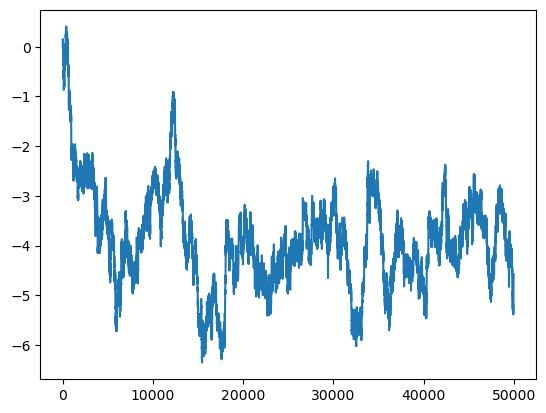

In [15]:
def trace(data,index):
  x = [i for i in range(len(data))]
  y = [data[i][index] for i in range(len(data))]
  plt.plot(x,y)

trace(test,0)

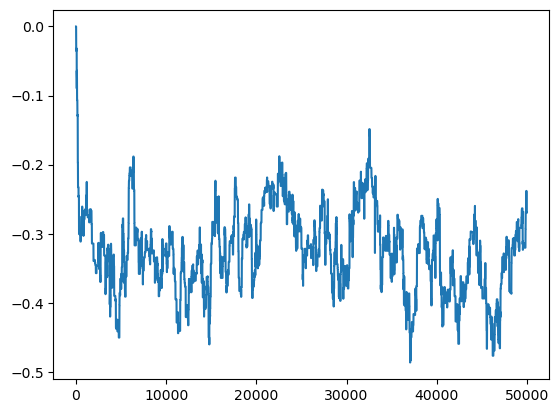

In [16]:
trace(test,1)

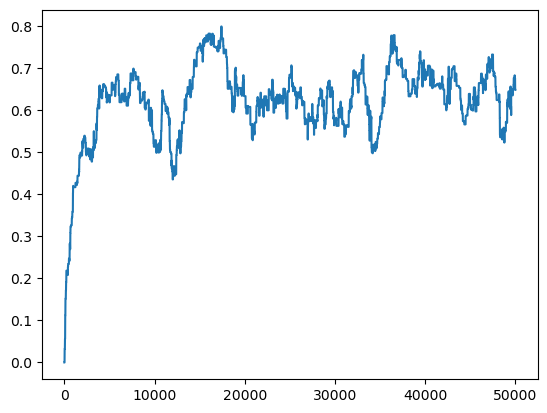

In [17]:
trace(test,2)

A great litmus test for logistic regression is accuracy, reviewing the above - we can see that B0 hovers around -4, B1 around -0.3 and B2 around 0.6. We'll apply this linear function to the input vector, X, pass through a sigmoid function, which returns the probability of class 1, and then assign 0 or 1 based on whether this probability is above or below 0.5.

In [18]:
def accuracy(X,C):
  scores = []
  marks = []
  for x,c in zip(X,C):
    x1 = x[0]
    x2 = x[1]
    z = -0.3*x1 +0.6*x2 -4
    p = sigmoid(z)
    pred = int(p>=0.5)
    if pred == c:
      scores.append(1)
      marks.append(1)
    else:
      scores.append(0)
      marks.append(6)
  return sum(scores)/len(scores), marks

acc = accuracy(X,Y)
acc[0]

0.8

80%, not bad!

To visualize our results, true positives are orange, true negatives are blue, and incorrect classifications of either class are captured by large bubbles, whereas all correct classifications are captured by small bubbles. From this, we can see that all misclassifications are generally close to the central data cluster. 

<Axes: >

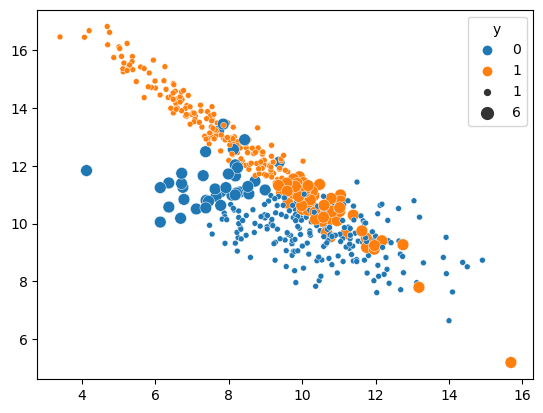

In [19]:
import pandas as pd
data = pd.DataFrame(data={'x1':X[:,0],'x2':X[:,1],'y':Y},columns=['x1','x2','y'])
sns.scatterplot(x=X[:,0],y=X[:,1],data=data,size=acc[1],hue='y')

# Hamiltonian Monte Carlo (HMC)

**The "ball in a bowl" physics analogy**

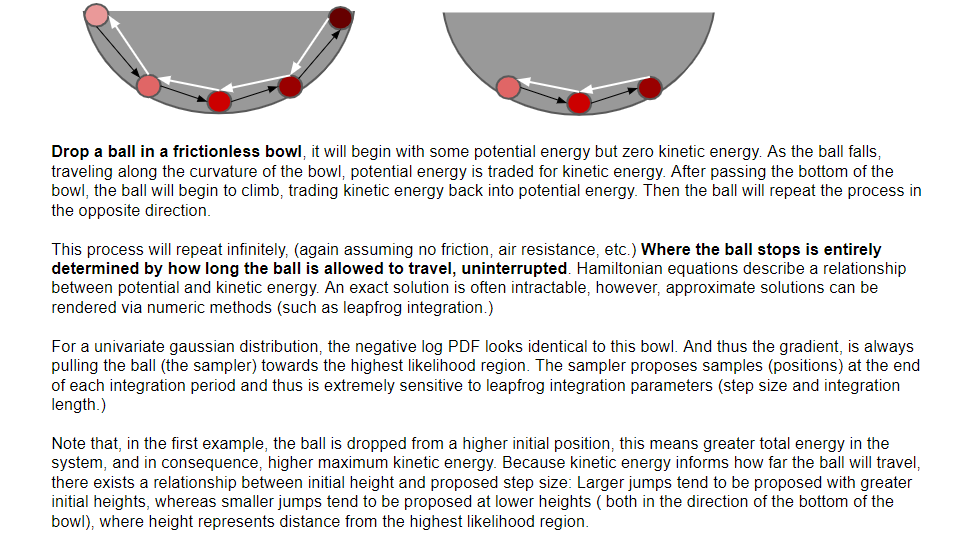

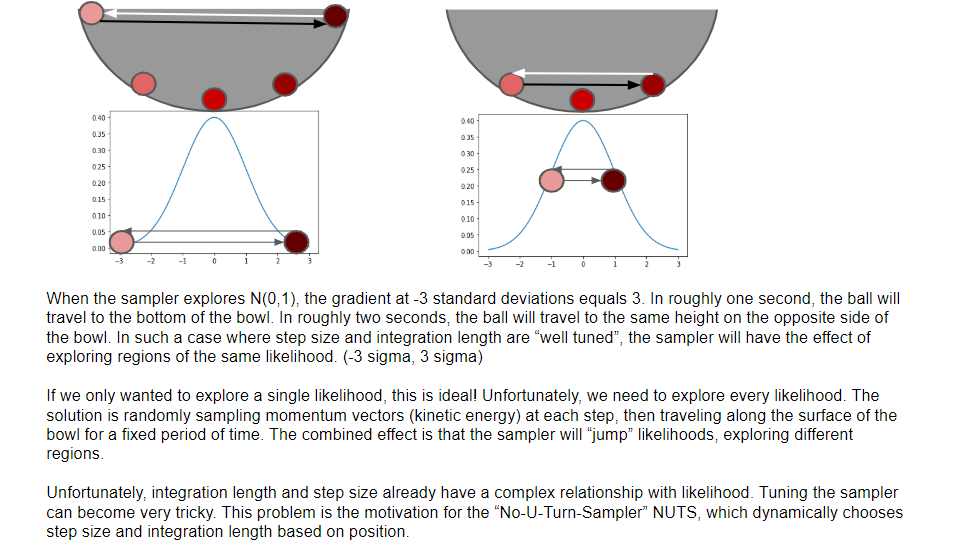

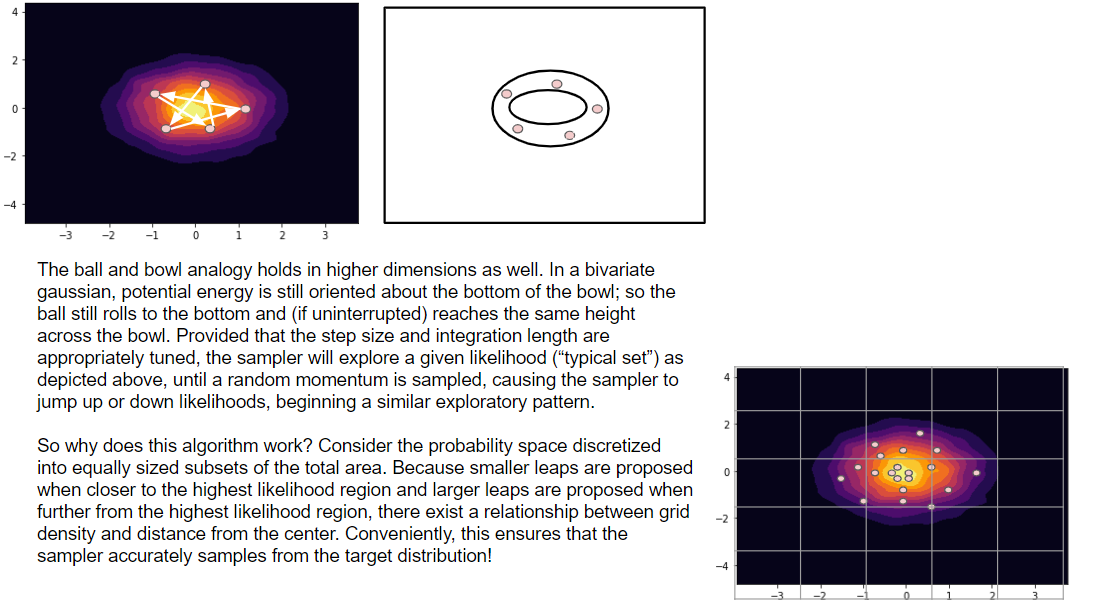

**Normal vs negative log normal: Gradient and distribution comparisons**

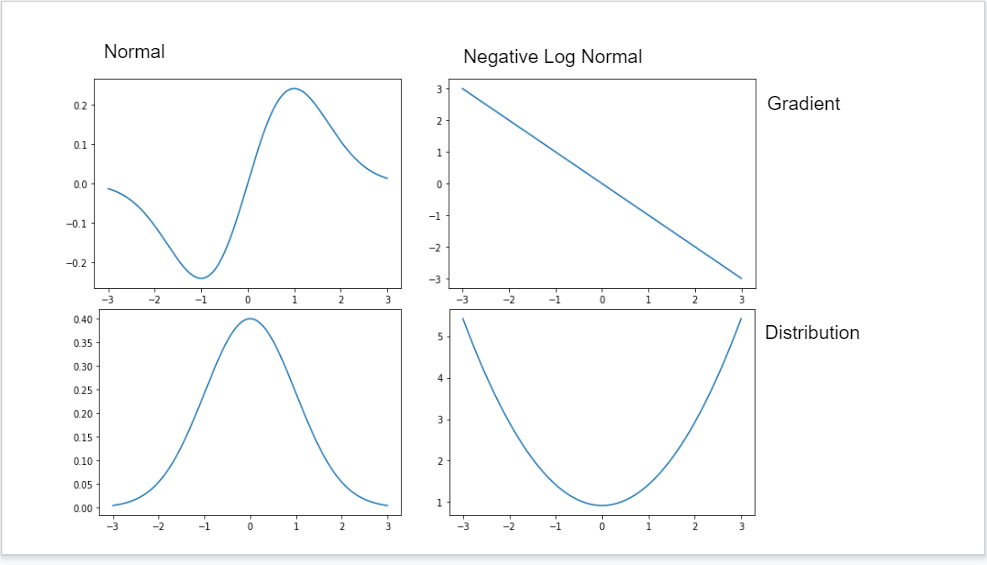

**A closer look at technical details**

Hamiltonian Monte Carlo is a variant of MH, but the proposal distribution adds more complexity. MH uses random walks to explore the probability space; as discussed, the likelihoods of current and proposed locations are compared for movement criteria. However, as dimensionality increases, the high likelihood region(s) composes (exponentially) less and less of the total area. In these cases, MH cannot efficiently explore all regions of the distribution and might return samples that are not truly representative of the distribution's shape.

HMC instead designs a scheme by which the size of the jump is proportionate to the (negative log) likelihood of the sampler's current position. When close to the high likelihood region(s), it proposes nearby positions; conversely, when far from these high likelihood region(s), larger jumps are proposed. The key is relating position to leap size.  

HMC loosely uses Hamiltonian mechanics to inform these jumps; namely, differential equations relating position and momentum to each other. Often, differential equations cannot be solved exactly, however various symplectic integration methods (such as leapfrog integration) can closely approximate the solution. These (differential) equations are: **(A) the gradient of position with respect to time and (B) the gradient of momentum with respect to time.** Leapfrog integration iteratively updates position and momentum in order to estimate where a particle will be given its current position and momentum.

**Variables and  gradients are as follows:**

```
Q = position
P = momentum 
V = potential energy
K = kinetic energy
T = times
dQ/dT = P # position wrt time equals momentum
dP/dT = -dV/dQ # momentum wrt time equals potential energy wrt position
```
Of note, position is updated by momentum, and momentum is updated by the change in potential energy wrt position. In our context, position means the specific input variable, x, in the neagtive log PDF. When the position is approaching the high likelihood region(s), the slope is near 0. But when far from said region(s), the slope is much steeper. The effect is that positions corresponding to moderate and low likelihoods experience a large gradient **in the direction of the highest likelihood region(s)**. This has the beneficial effect of taking big jumps when exploring moderate/low likelihood regions (most of the distribution) but small jumps when exploring high likelihood region(s). Refer to above graphics to conceptually consider why this might be beneficial.

The negative log PDF is used for multiple reasons: First, (in the context of the univariate gaussian) the log function undoes exponentiation, resulting in a parabolla; this means the slope becomes increaseingly steeper with distance from the expectation (no inflection points, tail slopes don't approach 0). Second, logarithms tend to limit the risk of numerical underflow and overflow. And third, logarithms tend to simplify differentiation, resulting in a less complex functions, which are easier to derive.    

As discussed in graphics above, if the step size and integration length are well tuned to the current position, the ball will roll down the bowl and back up to the same height on the opposing side; however, the sampler proposes new positions at the end of the integration period, not at intermediary steps in between; this has the effect of bouncing between positions at (or near) the same likelihood. In order to explore other likelihoods, a random increase or decrease in momentum is needed. 

These "momentum kicks" take the form of the proposal distribution in the familiar context of the MH algorithm. A kick is sampled, leapfrog integration uses hamiltonian mechanics to determine how far the sampler will "travel" (given a fixed integration interval.) It might not be obvious, but the proposal distribution is not yet symmeytric. If a ball rolls down the parabolla, it starts in a high position with high potential energy but low kinetic energy. As it rolls down the curve, it now has high kinetic energy but low potential energy. If the kinetic energy were to be spontaneously reversed, it would ensure that the ball would travel from point B, at the bottom of the parabolla, back up to its starting position, point A. And this correction of "flipping" the momentum ensures proposal distribution symmetry. 

In other words, to correct for the assymetric proposal distrbiution, the starting position and starting momentum is taken and compared to the ending position and **negative ending kinetic energy**, such that the motion could be reversed. With this correction, the sampler now behaves as though it had a symmetric proposal distribution. The math in the code below appears a bit tricky but this is solely due to the use of negative logarithms (ie division becomes subtraction, multiplication becomes addition and due to the negative log, the signs are reversed.) 

Inm previous sections, the exponential distribution was sampled using the beta distribution and the "hastings ratio" was computed to correct for the assyemtric distribution. Study this concept to better understand the hastings ratio in the context of HMC.

Of note, the step size and integration length variables in the code below inform the HMC sampler for how long to travel given some starting momentum and position. In general, it is very difficult to "tune the proposal distribution", meaning find a step size and integration length that suits generally any position/likelihood, which the sampler might explore. 

The slightest change to these variables can negatively affect HMC performance. For example, the hypothetical ball could start on the negative log gaussian slope above, roll all the ways to the top of the other side, and back again to the original position. This is known as a "U-turn" and is the basis for the aptly named "No U-Turn Sampler" or NUTS. In practice, there are no "one size fits all" step size and path length parameters. As such, NUTS is more common in practice than HMC. 

In [20]:
import numpy as np
import random
import scipy.stats as st
import matplotlib.pyplot as plt

def normal(x,mu,sigma):
    numerator = np.exp(-1*((x-mu)**2)/(2*sigma**2))
    denominator = sigma * np.sqrt(2*np.pi)
    return numerator/denominator

def neg_log_prob(x,mu,sigma):
    return -1*np.log(normal(x=x,mu=mu,sigma=sigma))

def HMC(mu=0.0,sigma=1.0,path_len=1,step_size=0.25,initial_position=0.0,epochs=1_000):
    # setup
    steps = int(path_len/step_size) # path_len and step_size are tricky parameters to tune...
    samples = [initial_position]
    momentum_dist = st.norm(0, 1) 
    # generate samples
    for e in range(epochs):
        q0 = np.copy(samples[-1])
        q1 = np.copy(q0)
        p0 = momentum_dist.rvs()        
        p1 = np.copy(p0) 
        dVdQ = -1*(q0-mu)/(sigma**2) # gradient of PDF wrt position (q0) aka potential energy wrt position

        # leapfrog integration begin
        for s in range(steps): 
            p1 += step_size*dVdQ/2 # as potential energy increases, kinetic energy decreases, half-step
            q1 += step_size*p1 # position increases as function of momentum 
            p1 += step_size*dVdQ/2 # second half-step "leapfrog" update to momentum    
        # leapfrog integration end        
        p1 = -1*p1 #flip momentum for reversibility     

        
        #metropolis acceptance
        q0_nlp = neg_log_prob(x=q0,mu=mu,sigma=sigma)
        q1_nlp = neg_log_prob(x=q1,mu=mu,sigma=sigma)        

        p0_nlp = neg_log_prob(x=p0,mu=0,sigma=1)
        p1_nlp = neg_log_prob(x=p1,mu=0,sigma=1)
        
        # Account for negatives AND log(probabiltiies)...
        target = q0_nlp - q1_nlp # P(q1)/P(q0)
        adjustment = p1_nlp - p0_nlp # P(p0)/P(p1)
        acceptance = target + adjustment # [P(q1)*P(p0)]/[P(q0)*P(p1)] 
        
        event = np.log(random.uniform(0,1))
        if event <= acceptance:
            samples.append(q1)
        else:
            samples.append(q0)
    
    return samples
        

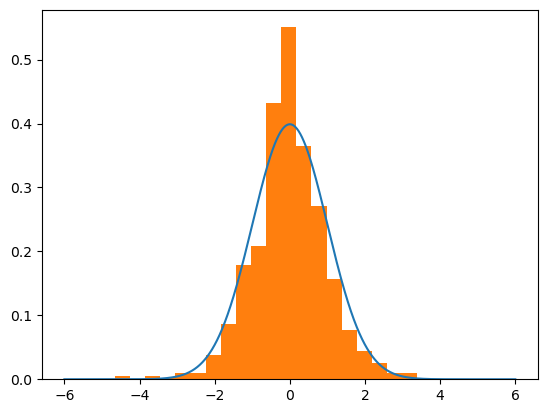

In [21]:
import matplotlib.pyplot as plt
mu = 0
sigma = 1
trial = HMC(mu=mu,sigma=sigma,path_len=1.5,step_size=0.25) #note the step_size and path_len parameters

lines = np.linspace(-6,6,10_000)
normal_curve = [normal(x=l,mu=mu,sigma=sigma) for l in lines]

plt.plot(lines,normal_curve)
plt.hist(trial,density=True,bins=20)
plt.show()

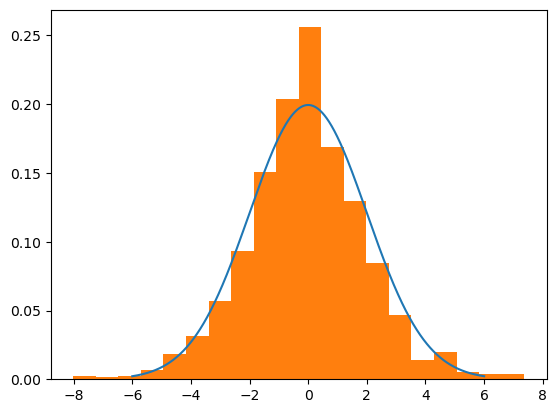

In [22]:
mu = 0
sigma = 2
trial = HMC(mu=mu,sigma=sigma,path_len=3,step_size=0.25) #note the change in step_size and path_len parameters...

lines = np.linspace(-6,6,10_000)
normal_curve = [normal(x=l,mu=mu,sigma=sigma) for l in lines]

plt.plot(lines,normal_curve)
plt.hist(trial,density=True,bins=20)
plt.show()